# Crime in Los Angeles: Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import time

In [2]:
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 1000)

## Loading the data and preliminary modifications

In [3]:
df = pd.read_csv(r"C:\Users\Utilisateur\Downloads\EDA - Crime in Los Angeles\crimes.csv")

In [4]:
crimes = df
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185715 entries, 0 to 185714
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   DR_NO         185715 non-null  int64 
 1   Date Rptd     185715 non-null  object
 2   DATE OCC      185715 non-null  object
 3   TIME OCC      185715 non-null  int64 
 4   AREA NAME     185715 non-null  object
 5   Crm Cd Desc   185715 non-null  object
 6   Vict Age      185715 non-null  int64 
 7   Vict Sex      185704 non-null  object
 8   Vict Descent  185705 non-null  object
 9   Weapon Desc   73502 non-null   object
 10  Status Desc   185715 non-null  object
 11  LOCATION      185715 non-null  object
dtypes: int64(3), object(9)
memory usage: 17.0+ MB


* The variable names are not necessarily conventional nor understandable for all. Since we don't have a lot of columns, we could rename them with a list of new column names.
* There are very few missing values, except for the Weapon description, since a missing value indicates no weapon reported.
* Looking at data types, the dates and times are either text (*DATE Rptd* & *DATE OCC*) or integers (*TIME OCC*).

In [5]:
# Renaming columns
new_names = ['id', 'date_reported', 'date_occurrence', 'time_occurrence', 'area_name', 'description',
             'age_vict', 'sex_vict', 'descent_vict', 'weapon', 'crime_status', 'crime_loc']
crimes.columns = new_names

# Converting dates to datetime type
crimes['date_reported'] = pd.to_datetime(crimes['date_reported'])
crimes['date_occurrence'] = pd.to_datetime(crimes['date_occurrence'])

### Converting `time_occurrence` into time

At first, we tried to convert this variable to time using the 'time' package, but couldn't get coherent outputs. Therefore, let's try to define a function for converting an integer into a 24h-Military time. The function has to:
- compute the number of hours, which is the *integer* // 100
- get the number of minutes, which is *integer* % 100
- return a datetime object of the form HH:MM

In [6]:
crimes['time_occurrence'].head(10)

0    1110
1    1620
2    1200
3     635
4     900
5    1000
6    1200
7    1335
8       1
9    1700
Name: time_occurrence, dtype: int64

In [7]:
# Function definition
def int_to_time(integer):
    hours = integer // 100
    minutes = integer % 100
    time = dt.strptime(f'{hours}:{minutes}', '%H:%M') # Converting a time string into datetime object.
    time = time.time() # With the .time() method, we only keep the time part of the datetime object.
    return(time)

In [8]:
# Let's test the function
test = crimes['time_occurrence'].head(10)
test = test.apply(lambda x: int_to_time(x))
test

0    11:10:00
1    16:20:00
2    12:00:00
3    06:35:00
4    09:00:00
5    10:00:00
6    12:00:00
7    13:35:00
8    00:01:00
9    17:00:00
Name: time_occurrence, dtype: object

The function seems to work nicely. The only problem is that the data type returned is string, while we might want to be able to make computations with time. Therefore, we will produce a new columns with the corresponding number of secondes.

In [9]:
# Now converting the whole column, using map() this time
crimes['time_occurrence'] = crimes['time_occurrence'].map(int_to_time)

# And creating a new column for time computations
crimes['time_occurrence_sec'] = crimes['time_occurrence'].apply(lambda x: x.hour * 3600 + x.minute * 60)

In [10]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185715 entries, 0 to 185714
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   185715 non-null  int64         
 1   date_reported        185715 non-null  datetime64[ns]
 2   date_occurrence      185715 non-null  datetime64[ns]
 3   time_occurrence      185715 non-null  object        
 4   area_name            185715 non-null  object        
 5   description          185715 non-null  object        
 6   age_vict             185715 non-null  int64         
 7   sex_vict             185704 non-null  object        
 8   descent_vict         185705 non-null  object        
 9   weapon               73502 non-null   object        
 10  crime_status         185715 non-null  object        
 11  crime_loc            185715 non-null  object        
 12  time_occurrence_sec  185715 non-null  int64         
dtypes: datetime64[

## First look at the data

### Numeric variables

In [11]:
crimes.describe()

,id,date_reported,date_occurrence,age_vict,time_occurrence_sec
count,1.857150e+05,185715,185715,185715.000000,185715.000000
mean,2.255781e+08,2022-12-12 01:50:25.325902848,2022-11-27 19:04:55.711170560,39.999257,47250.074792
min,2.009072e+08,2022-06-01 00:00:00,2020-01-01 00:00:00,2.000000,60.000000
25%,2.210108e+08,2022-09-04 00:00:00,2022-08-25 00:00:00,28.000000,30600.000000
50%,2.220114e+08,2022-12-10 00:00:00,2022-12-02 00:00:00,37.000000,49200.000000
75%,2.310044e+08,2023-03-20 00:00:00,2023-03-12 00:00:00,50.000000,66600.000000
max,2.399097e+08,2023-07-03 00:00:00,2023-07-03 00:00:00,99.000000,86340.000000
std,5.017438e+06,NaN,NaN,15.450227,23631.669195


- The average age of the victims is 40 years old. The standard deviation is quite important and the interquartile range of [28:50] makes sense. The min value of age is 2, which might be explanable in a given context
- The median time of occurence of crimes is 13:40

In [12]:
# Little tool to compute time from seconds
time = 49200
print(f'{str(time//3600)}:{str((time%3600)//60)}')

13:40


### Categorical variables

In [13]:
crimes.select_dtypes('object').head()

,time_occurrence,area_name,description,sex_vict,descent_vict,weapon,crime_status,crime_loc
0,11:10:00,Southwest,THEFT OF IDENTITY,F,B,NaN,Invest Cont,2500 S SYCAMORE AV
1,16:20:00,Olympic,THEFT OF IDENTITY,M,H,NaN,Invest Cont,3300 SAN MARINO ST
2,12:00:00,Hollywood,THEFT OF IDENTITY,M,H,NaN,Invest Cont,1900 TRANSIENT
3,06:35:00,77th Street,THEFT OF IDENTITY,M,H,NaN,Invest Cont,6200 4TH AV
4,09:00:00,Rampart,THEFT OF IDENTITY,M,B,NaN,Invest Cont,1200 W 7TH ST


#### Attempt to categorize each crime `description`

In [14]:
# Let's find out how many descriptions and crime_status exist
print(crimes['description'].nunique())
print(crimes['crime_status'].nunique())

104
6


Here, I used ChatGPT to classify these crimes in 10 categories, as follows. We can then use this dictionary to assign a category to each crime recorded in the **crimes** DataFrame.

In [15]:
crime_categories = {
    "Theft": [
        'THEFT OF IDENTITY',
        'THEFT PLAIN - PETTY ($950 & UNDER)',
        'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
        'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
        'THEFT PLAIN - ATTEMPT',
        'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
        'THEFT, PERSON',
        'THEFT FROM PERSON - ATTEMPT',
        'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
        'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
        'SHOPLIFTING - ATTEMPT',
        'PURSE SNATCHING',
        'PURSE SNATCHING - ATTEMPT',
        'BIKE - STOLEN',
        'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)'
    ],
    "Burglary": [
        'BURGLARY',
        'BURGLARY FROM VEHICLE',
        'BURGLARY, ATTEMPTED',
        'BURGLARY FROM VEHICLE, ATTEMPTED'
    ],
    "Fraud": [
        'DOCUMENT FORGERY / STOLEN FELONY',
        'BUNCO, GRAND THEFT',
        'CREDIT CARDS, FRAUD USE ($950 & UNDER)',
        'UNAUTHORIZED COMPUTER ACCESS',
        'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
        'DOCUMENT WORTHLESS ($200 & UNDER)',
        'DOCUMENT WORTHLESS ($200.01 & OVER)',
        'COUNTERFEIT',
        'GRAND THEFT / INSURANCE FRAUD'
    ],
    "Assault": [
        'INTIMATE PARTNER - SIMPLE ASSAULT',
        'INTIMATE PARTNER - AGGRAVATED ASSAULT',
        'BATTERY - SIMPLE ASSAULT',
        'CRIMINAL THREATS - NO WEAPON DISPLAYED',
        'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
        'OTHER ASSAULT',
        'BATTERY POLICE (SIMPLE)',
        'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
        'BRANDISH WEAPON'
    ],
    "Property Crime": [
        'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
        'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
        'ARSON',
        'ILLEGAL DUMPING'
    ],
    "Human Trafficking": [
        'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE'
    ],
    "Sexual Crimes": [
        'ORAL COPULATION',
        'INDECENT EXPOSURE',
        'PANDERING'
    ],
    "Court Violations": [
        'VIOLATION OF RESTRAINING ORDER',
        'VIOLATION OF COURT ORDER',
        'CONTEMPT OF COURT',
        'VIOLATION OF TEMPORARY RESTRAINING ORDER'
    ],
    "Miscellaneous": [
        'OTHER MISCELLANEOUS CRIME',
        'TRESPASSING',
        'THREATENING PHONE CALLS/LETTERS',
        'DISTURBING THE PEACE',
        'EXTORTION',
        'FALSE POLICE REPORT',
        'STALKING',
        'VEHICLE - ATTEMPT STOLEN',
        'BUNCO, ATTEMPT',
        'ATTEMPTED ROBBERY',
        'PIMPING',
        'KIDNAPPING',
        'CRIMINAL HOMICIDE',
        'FALSE IMPRISONMENT',
        'FAILURE TO YIELD',
        'SHOTS FIRED AT INHABITED DWELLING',
        'DISCHARGE FIREARMS/SHOTS FIRED',
        'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT',
        'THROWING OBJECT AT MOVING VEHICLE',
        'PROWLER',
        'BATTERY ON A FIREFIGHTER',
        'KIDNAPPING - GRAND ATTEMPT',
        'WEAPONS POSSESSION/BOMBING',
        'RESISTING ARREST',
        'TELEPHONE PROPERTY - DAMAGE',
        'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01',
        'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER',
        'DISRUPT SCHOOL',
        'BOMB SCARE',
        'RECKLESS DRIVING',
        'CRUELTY TO ANIMALS',
        'CONTRIBUTING',
        'DRUNK ROLL',
        'BLOCKING DOOR INDUCTION CENTER',
        'FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)',
        'BIGAMY',
        'DRIVING WITHOUT OWNER CONSENT (DWOC)',
        'CONSPIRACY',
        'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
        'BRIBERY'
    ],
    "Employee Crimes": [
        'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
        'DISHONEST EMPLOYEE - GRAND THEFT',
        'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)',
        'DISHONEST EMPLOYEE - PETTY THEFT',
        'DISHONEST EMPLOYEE ATTEMPTED THEFT'
    ],
    "Petty Theft": [
        'TILL TAP - PETTY ($950 & UNDER)',
        'THEFT, COIN MACHINE - PETTY ($950 & UNDER)',
        'TILL TAP - GRAND THEFT ($950.01 & OVER)'
    ]
}

# Now we reverse the dictionary so that it can be used to map a category to each crime description
reversed_dict = {}

for key, value in crime_categories.items():
    for element in value:
        reversed_dict[element] = key

In [16]:
# Now, let's map the reversed_dict to each record of the dataset

crimes['crime_cat'] = crimes['description'].map(reversed_dict)
crimes[['description', 'crime_cat']]

,description,crime_cat
0,THEFT OF IDENTITY,Theft
1,THEFT OF IDENTITY,Theft
2,THEFT OF IDENTITY,Theft
3,THEFT OF IDENTITY,Theft
4,THEFT OF IDENTITY,Theft
...,...,...
185710,"BUNCO, GRAND THEFT",Fraud
185711,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",Property Crime
185712,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Assault
185713,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Assault


In [17]:
# Simply reordering the columns of the dataframe

columns_ordered = ['id', 'date_reported', 'date_occurrence', 'time_occurrence', 'time_occurrence_sec',
                    'area_name', 'crime_cat','description', 'age_vict', 'sex_vict', 'descent_vict',
                    'weapon', 'crime_status', 'crime_loc']

crimes = crimes[columns_ordered]

## Exploratory Data Analysis

### First sight

In [18]:
crimes.select_dtypes(include = [np.number, np.datetime64]).head(1)

,id,date_reported,date_occurrence,time_occurrence_sec,age_vict
0,220314085,2022-07-22,2020-05-12,40200,27


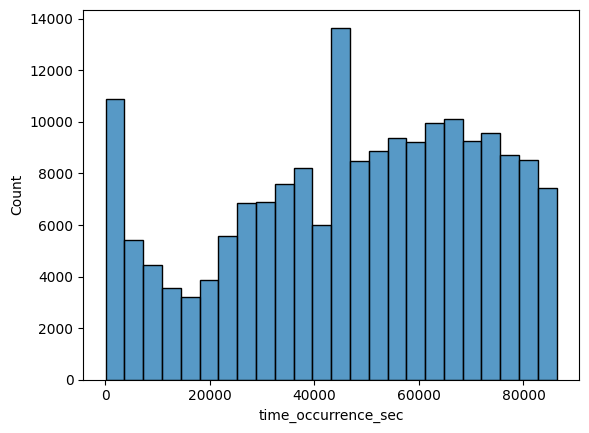

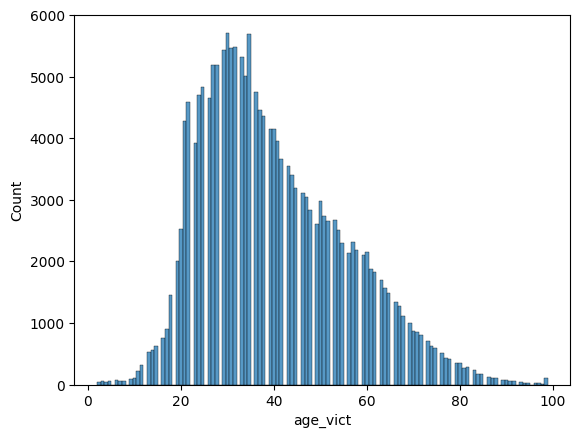

In [19]:
# Let's plot the distribution of time_occurrence_sec and age_vict

sns.histplot(data = crimes, x = 'time_occurrence_sec', bins = 24)
plt.show()

sns.histplot(data = crimes, x = 'age_vict')
plt.show()

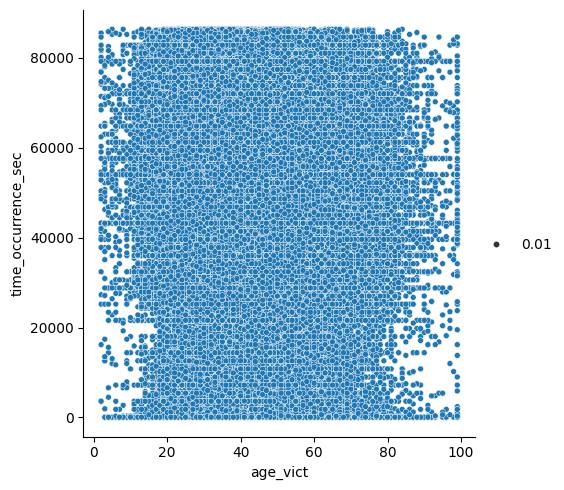

In [20]:
# Is there a relationship between the age of the victims and the time of the assault? 

sns.relplot(x = 'age_vict',
            y = 'time_occurrence_sec',
            data = crimes,
            kind = 'scatter',
            size = 0.01)

In [21]:
crimes[['age_vict', 'time_occurrence_sec']].corr()

,age_vict,time_occurrence_sec
age_vict,1.000000,-0.015126
time_occurrence_sec,-0.015126,1.000000


Even though the most frequent time of the day for an assault is around the middle of the day, there doesn't appear to be a clear relationship between the age of the victims and the timing of there assault. Let's now take a look at the categorical variables.

In [22]:
crimes.select_dtypes('object').head(1)

,time_occurrence,area_name,crime_cat,description,sex_vict,descent_vict,weapon,crime_status,crime_loc
0,11:10:00,Southwest,Theft,THEFT OF IDENTITY,F,B,NaN,Invest Cont,2500 S SYCAMORE AV


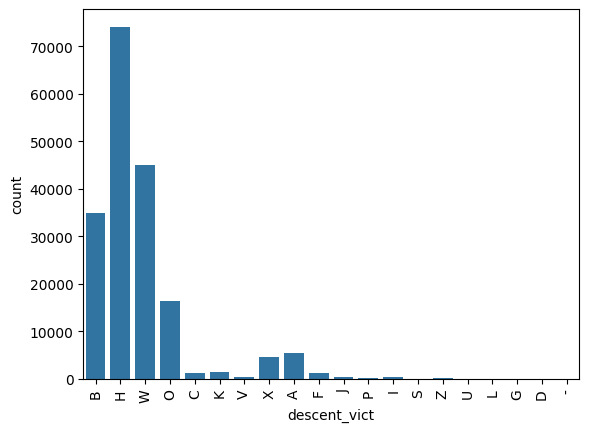

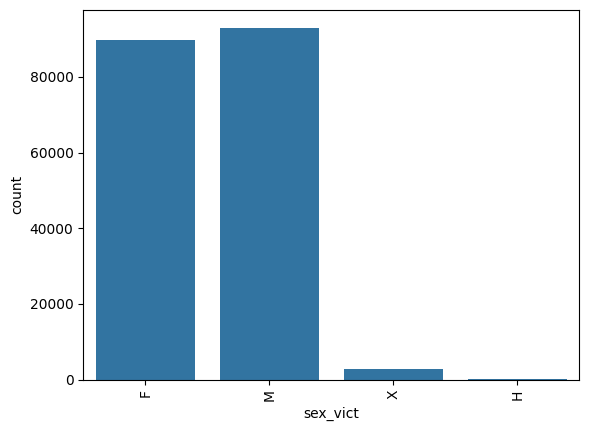

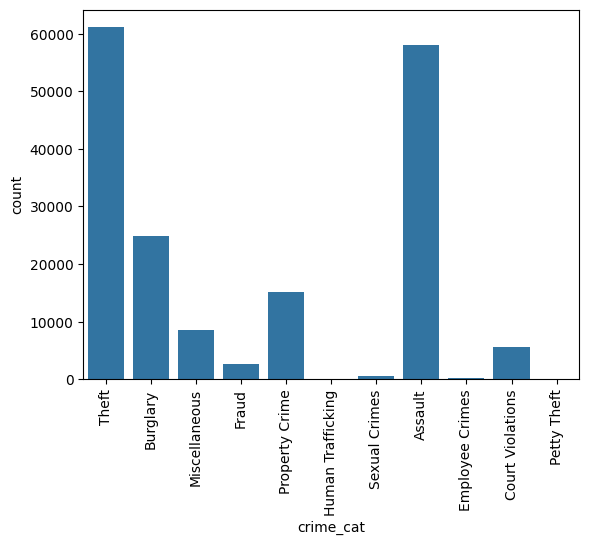

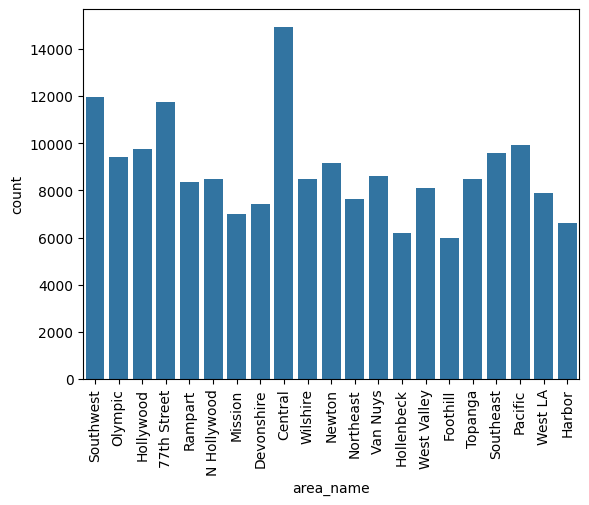

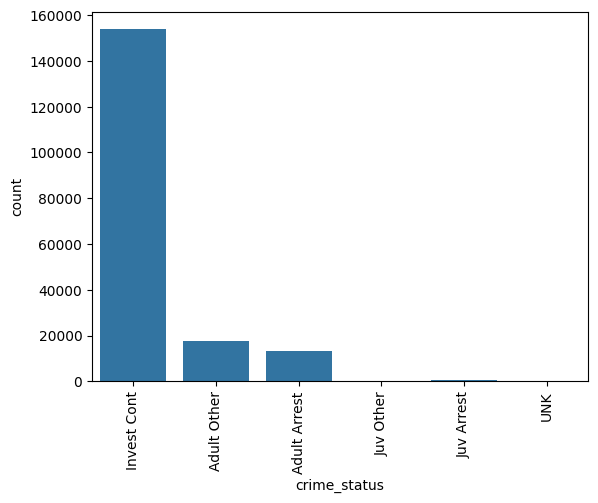

In [23]:
# Distributions of all categorical variables
for column in ['descent_vict', 'sex_vict', 'crime_cat', 'area_name', 'crime_status']:
    sns.countplot(data = crimes, x = column)
    plt.xticks(rotation = 90)
    plt.show()

It's impressive how near the majority of the crimes were targetting Hispanic people. Now, of course, this count should be put in perspective with the total number of hispanic people in Los Angeles, but it's still impressive. Then come white people and then black people.

### Investigating more precise questions

In [24]:
crimes.head()

,id,date_reported,date_occurrence,time_occurrence,time_occurrence_sec,area_name,crime_cat,description,age_vict,sex_vict,descent_vict,weapon,crime_status,crime_loc
0,220314085,2022-07-22,2020-05-12,11:10:00,40200,Southwest,Theft,THEFT OF IDENTITY,27,F,B,NaN,Invest Cont,2500 S SYCAMORE AV
1,222013040,2022-08-06,2020-06-04,16:20:00,58800,Olympic,Theft,THEFT OF IDENTITY,60,M,H,NaN,Invest Cont,3300 SAN MARINO ST
2,220614831,2022-08-18,2020-08-17,12:00:00,43200,Hollywood,Theft,THEFT OF IDENTITY,28,M,H,NaN,Invest Cont,1900 TRANSIENT
3,231207725,2023-02-27,2020-01-27,06:35:00,23700,77th Street,Theft,THEFT OF IDENTITY,37,M,H,NaN,Invest Cont,6200 4TH AV
4,220213256,2022-07-14,2020-07-14,09:00:00,32400,Rampart,Theft,THEFT OF IDENTITY,79,M,B,NaN,Invest Cont,1200 W 7TH ST


#### a) When do the most crime happen?

([<matplotlib.axis.XTick at 0x1df246c17d0>,
 [Text(0, 0, '0:00'),
  Text(7200, 0, '2:00'),
  Text(14400, 0, '4:00'),
  Text(21600, 0, '6:00'),
  Text(28800, 0, '8:00'),
  Text(36000, 0, '10:00'),
  Text(43200, 0, '12:00'),
  Text(50400, 0, '14:00'),
  Text(57600, 0, '16:00'),
  Text(64800, 0, '18:00'),
  Text(72000, 0, '20:00'),
  Text(79200, 0, '22:00')])

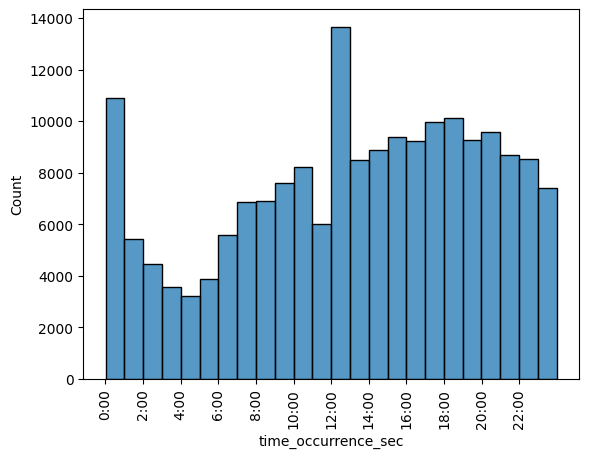

In [25]:
# First, overall

# Lets define the labels for the plot, I'm choosing to display hours two-by-two on the x-axis
hours_a_day = [f'{str(hour)}:00' for hour in range(0,24,2)]
# We need to pass them into a dictionnary so that they are mapped correctly to the values in seconds
hours_a_day_sec = [sec for sec in range(0,3600*24,3600*2)]

sns.histplot(data = crimes, x = 'time_occurrence_sec', bins = 24)
plt.xticks(hours_a_day_sec, hours_a_day, rotation = 90)

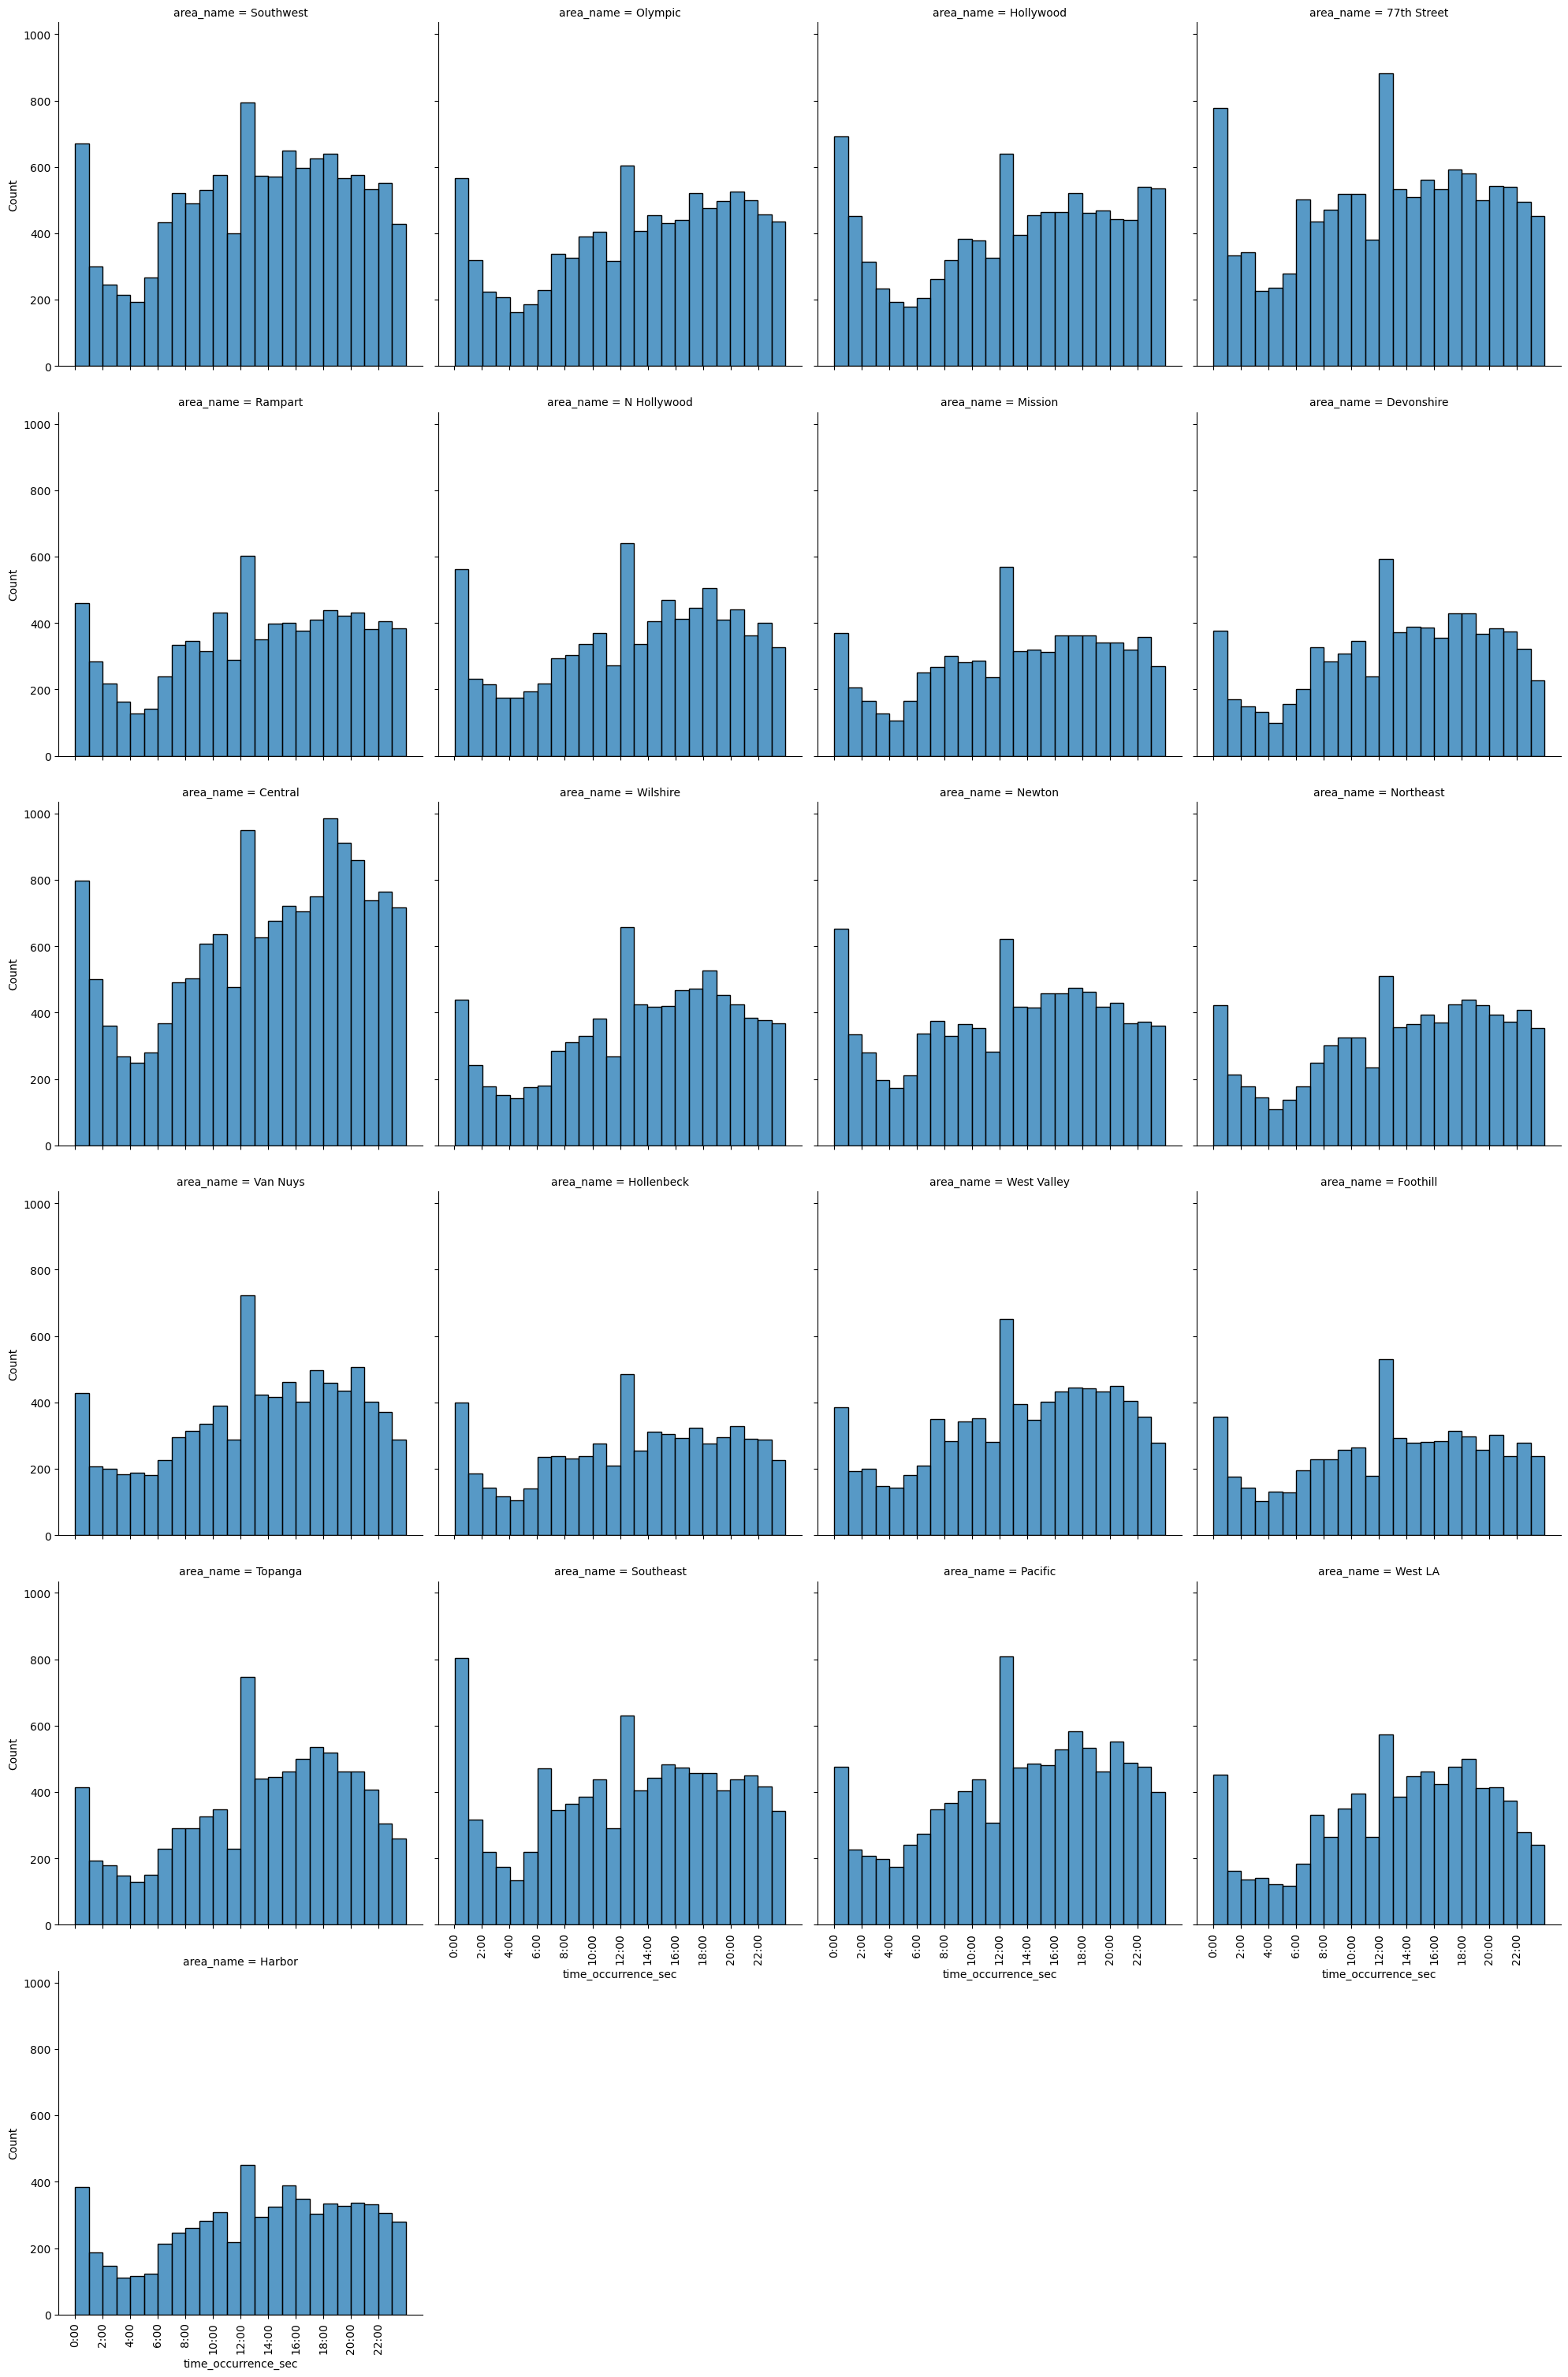

In [26]:
# Second, by area
g = sns.displot(x = 'time_occurrence_sec',
            data = crimes,
            col = 'area_name',
            col_wrap = 4,
            bins = 24)

# Iterate over each facet and set the tick labels
for ax in g.axes.flat:
    # Set the x-ticks positions
    ax.set_xticks(hours_a_day_sec)
    # Set the x-tick labels
    ax.set_xticklabels(hours_a_day, rotation=90)

So, overall as well as in each single area, the time of the day when most crimes happen is 12:00AM. This is interesting because intuitively, we might think that most crimes happen during night time. However, these are absolute values meaning that it also makes sense that more crimes happen since more people are out there than at night. 

##### Which area has the highest frequency of night crimes?

In [27]:
# Here, night is defined as the time period between 10:00PM and 3:59AM
night_time = (crimes['time_occurrence_sec'] >= 22*3600) | (crimes['time_occurrence_sec'] <= 3*3600 + 59*60)

In [28]:
# Let's subset crimes to get night_crimes
night_crimes = crimes.loc[night_time,:]

# Quick check
night_crimes[['id', 'time_occurrence']].sample(10)

# Looks good

,id,time_occurrence
168161,230610602,01:00:00
158153,231710190,23:45:00
126470,231213730,00:01:00
107912,230611692,02:00:00
70138,220216834,22:00:00
151995,231711247,02:10:00
26246,220619728,22:00:00
52289,221011458,23:20:00
171248,230212596,02:00:00
170650,231010113,02:40:00


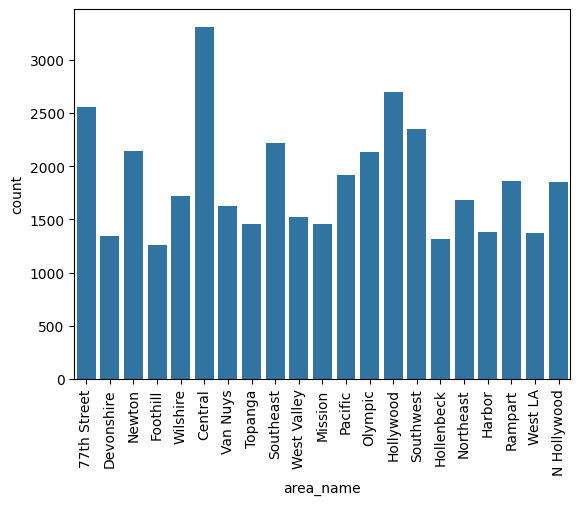

In [29]:
# Now, let's plot the number of night crimes in each area
sns.countplot(x = 'area_name',
              data = night_crimes)
plt.xticks(rotation = 90)
plt.show()

Central, Hollywood, and 77th Street are the areas where the most night crimes happen. This might be due to high numbers of tourists in Central and Hollywood. Later, we'll have a look at the severity of the crimes that are perpetrated during night time in these 3 areas. Logically, since Hollywood is a highly touristic place, we might expect few "Very severe" crimes, and more "Severe" and "Moderate" ones.

#### b) Crime severity

Let's order the crime categories by crime severity. The severity is based on the perceived life danger for the victim, since the analysis is dedicated to the LA Police Department. Of course, this severity ranking remains arbitrary and might not take into account the diversity of severity within each category, but it might help us get a big picture overview of crimes severity in Los Angeles. 

In [30]:
# Let's look at the various categories
# We will let 'Miscellaneous' aside because it contains a wide variety of crime descriptions
crimes['crime_cat'].unique()
severity_ranking = {'Human Trafficking' : 'Very severe',
                    'Sexual Crimes' : 'Very severe',
                    'Assault' : 'Very severe',
                    'Employee Crime' : 'Severe', 
                    'Burglary' : 'Severe',
                    'Property Crime' : 'Severe',
                    'Theft' : 'Severe',
                    'Fraud' : 'Moderate', 
                    'Court Violations': 'Moderate',
                    'Petty Theft': 'Moderate'}

crimes['severity'] = crimes['crime_cat'].map(severity_ranking)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13892\297502713.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes['severity'] = crimes['crime_cat'].map(severity_ranking)


##### When do the most severe crimes happen the most ?

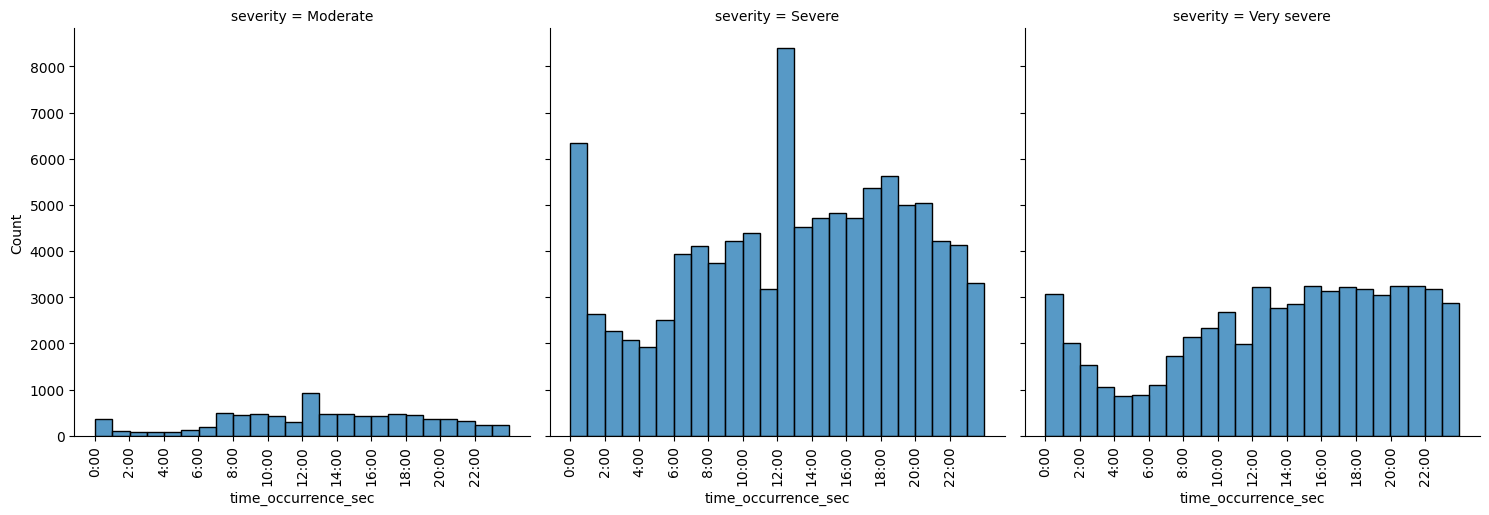

In [31]:
g = sns.displot(x = 'time_occurrence_sec',
            data = crimes, 
            col = 'severity',
            col_order = ['Moderate', 'Severe', 'Very severe'],
            bins = 24)

for ax in g.axes.flat:
    ax.set_xticks(hours_a_day_sec)
    ax.set_xticklabels(hours_a_day, rotation=90)

Interstingly enough, there is **no single time** in the day witnessing more Very severe crimes. Again, as these are absolute values, we may formulate the hypothesis that in the evening and beginning of the night (until 1:00AM), the probability to be the victim of a very severe crime increases with time. This would be the case if the number of people in the streets actually declines from 12:00 AM to 1:00 AM, while the number of very severe crimes remains approximately constant.  

##### Where do the most severe crimes happen the most ?

In [32]:
# First we group by severity and area name to get the number of each crime of each severity and area.
# Second, we group by area, and select the severity column because we want to count the total number of crimes that do not display NaN as severity in the area
# Finally, we compute the ratio of each crime severity in each area.
crimes['severity_rate_area'] = crimes.groupby(['severity','area_name'])['area_name'].transform('count')/crimes.groupby('area_name')['severity'].transform('count')

# Then we drop duplicates to get each rate only once
severity_rates = crimes[['area_name', 'severity', 'severity_rate_area']].drop_duplicates(subset = ['area_name', 'severity'])

# Finally, we order the resulting dataframe by area_name and severity (luckily, alphabetial order works perfect for severity categories)
severity_rates = severity_rates.sort_values(by = ['area_name', 'severity'])

# Let's also drop missing values for clarity sake
severity_rates.dropna(subset = 'severity')

# The dataframe is ready!

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13892\4169187818.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes['severity_rate_area'] = crimes.groupby(['severity','area_name'])['area_name'].transform('count')/crimes.groupby('area_name')['severity'].transform('count')


,area_name,severity,severity_rate_area
85,77th Street,Moderate,0.050697
3,77th Street,Severe,0.476780
20,77th Street,Very severe,0.472523
315,Central,Moderate,0.013290
11,Central,Severe,0.629817
1215,Central,Very severe,0.356894
29,Devonshire,Moderate,0.066725
10,Devonshire,Severe,0.633304
130,Devonshire,Very severe,0.299971
1077,Foothill,Moderate,0.084599


In [33]:
# Where do the most severe crimes happen the most ?
vs_crime_area = severity_rates.loc[severity_rates['severity'] == 'Very severe',:].nlargest(n = 5, columns = 'severity_rate_area')
vs_crime_area['severity_rate_area'] = vs_crime_area['severity_rate_area'].round(3) 
display(vs_crime_area) # note that 'vs_crime_area' stands for 'very severe_crime_area'

# As a comparison
severity_rates.groupby('severity')['severity_rate_area'].agg('mean', 'median').to_dict()

,area_name,severity,severity_rate_area
20,77th Street,Very severe,0.473
114,Southeast,Very severe,0.455
790,Rampart,Very severe,0.450
326,Newton,Very severe,0.435
377,Harbor,Very severe,0.425


{'Moderate': 0.05230846857195922,
 'Severe': 0.6003006315444013,
 'Very severe': 0.3473908998836394}

**77th Street, Southeast, Rampart, Newton and Harbor** are the 5 areas in Los Angeles with the highest ratios of very severe crimes. 

##### To what age group do very severe crimes happen the most?

In [34]:
# We assign each age_vict to an age group using the .cut() method
age_bins = [0,17,25,34,44,54,64,122]
age_groups = ['0-17', '18-25', '26-34', '35-44', '45-54', '55-64', '65+']
crimes['age_group'] = pd.cut(crimes['age_vict'],
                             labels = age_groups,
                             bins = age_bins) 

# Quick check
crimes[['age_vict', 'age_group']].sample(10)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13892\634952944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes['age_group'] = pd.cut(crimes['age_vict'],


,age_vict,age_group
111963,41,35-44
3998,59,55-64
28245,47,45-54
117490,18,18-25
24655,33,26-34
26229,32,26-34
137849,61,55-64
60786,25,18-25
45786,28,26-34
82583,31,26-34


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13892\2813041145.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crimes.groupby('age_group')['id'].count()


age_group
0-17      4528
18-25    28291
26-34    47470
35-44    42157
45-54    28353
55-64    20169
65+      14747
Name: id, dtype: int64

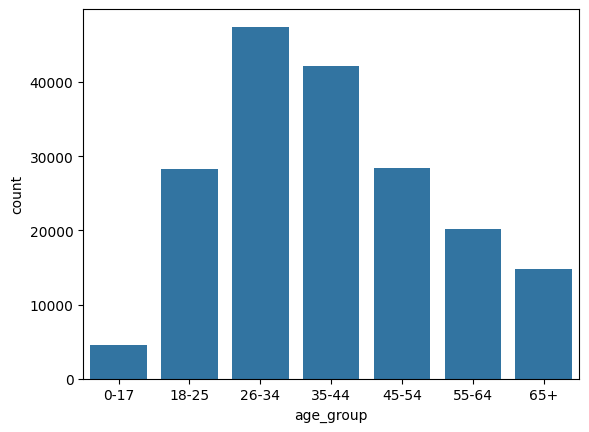

In [35]:
# First and foremost, let's take a look at the overall frequency of crimes per age_group
sns.countplot(x = 'age_group', 
              data = crimes)
crimes.groupby('age_group')['id'].count()

In [36]:
# Now, let's investigate the severity of crimes per age_group.
# To do so, we can repeat the operation of the last question with the age_group variable
crimes['severity_rate_age_group'] = crimes.groupby(['age_group', 'severity'])['severity'].transform('count')/crimes.groupby('age_group')['severity'].transform('count')

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13892\3387774727.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crimes['severity_rate_age_group'] = crimes.groupby(['age_group', 'severity'])['severity'].transform('count')/crimes.groupby('age_group')['severity'].transform('count')
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13892\3387774727.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crimes['severity_rate_age_group'] = crimes.groupby(['age_group', 'severity'])['severity'].transform('count')/crimes.groupby('age_group')['severity'].transform('count')
C:\Users\Utilisateur\AppData\Local\Temp\ip

In [37]:
# Again, we drop duplicates on age_group to get a summary DataFrame
severity_rates_age_group = crimes[['age_group', 'severity', 'severity_rate_age_group']].drop_duplicates(subset = ['age_group','severity'])

# Finally, we order the summary DataFrame and drop missing values
print('There are', crimes['severity'].isna().sum(), 'missing values in the severity variable of the crimes DataFrame.')
severity_rates_age_group = severity_rates_age_group.sort_values(by = ['age_group', 'severity']).dropna(subset = 'severity')

There are 17613 missing values in the severity variable of the crimes DataFrame.


In [38]:
severity_rates_age_group.loc[severity_rates_age_group['severity']=='Very severe',:]

,age_group,severity,severity_rate_age_group
26,0-17,Very severe,0.830119
20,18-25,Very severe,0.389659
113,26-34,Very severe,0.349039
55,35-44,Very severe,0.333773
95,45-54,Very severe,0.334544
190,55-64,Very severe,0.327100
490,65+,Very severe,0.252482


An astonishing **83%** of crimes perpetrated against youngsters (0-17 yo) are categorized as **'Very severe'**, making it the age group that is victim of the highest ratio of highly dangerous crimes. One might argue that it is due to the overall minority that represent this age_group (only 2.5% of all crimes registered). Still this ratio was computed over more than 3000 crimes, which is enough to consider them seriously.

##### Severity in night crimes in 77th Street, Hollywood and Central

We saw earlier that 77th Street, Hollywood and Central were the areas with the highest frequency of night crimes. Let's look at how severe they are in each of these areas.

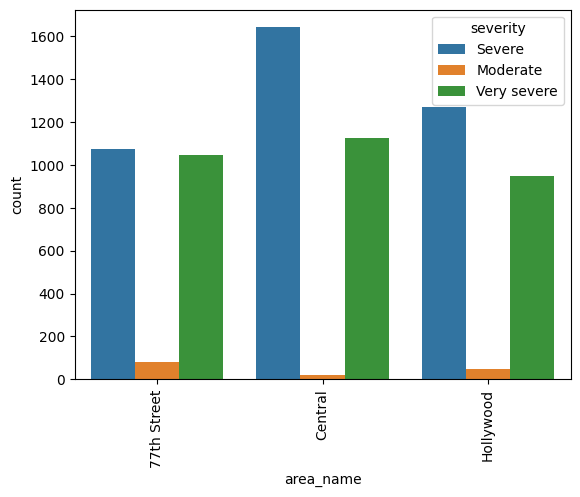

In [39]:
# First, we need to refresh the night_crimes dataframe since we've create a severity variable since.
night_crimes = crimes.loc[night_time,:]

# Let's plot the number of night crimes in each of these 3 area
sns.countplot(x = 'area_name',
              data = night_crimes.loc[night_crimes['area_name'].isin(['77th Street', 'Hollywood', 'Central'])],
              hue = 'severity')
plt.xticks(rotation = 90)
plt.show()

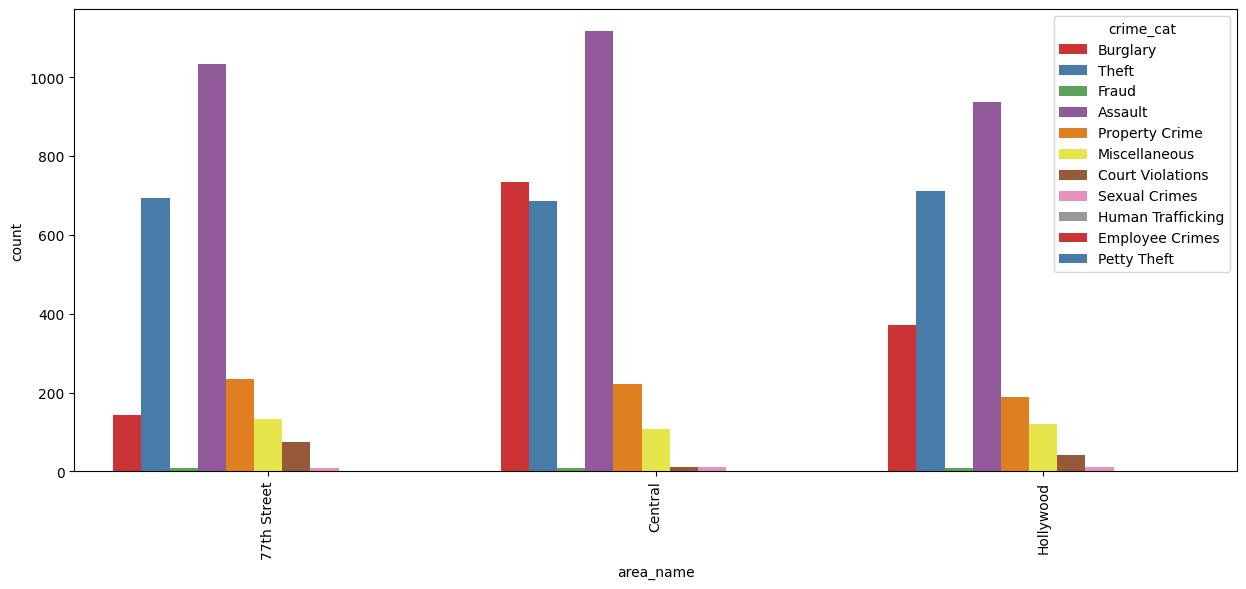

In [40]:
# Let's have a closer look at the categories
plt.subplots(figsize=(15, 6))
sns.countplot(x = 'area_name',
              data = night_crimes.loc[night_crimes['area_name'].isin(['77th Street', 'Hollywood', 'Central'])],
              hue = 'crime_cat', 
              palette = 'Set1')
plt.xticks(rotation = 90)
plt.show()

The vast majority of crimes in these areas at night are Severe or Very Severe, namely being assaults and thefts. Moreover a high number of burglaries are registered in Central.

#### c) Time to report

Let's now look at the time people need to report a crime. To do so, we will compare the 'date_reported' and the 'date_occurrence'.

In [41]:
# To begin with, we compute the difference between 'date_reported' and 'date_occurrence' and store it inside of the 'reporting_delay' column.
crimes['reporting_delay'] = crimes['date_reported'] - crimes['date_occurrence']

# Quick check
crimes[['reporting_delay', 'date_occurrence', 'date_reported']].sample(5)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13892\2710007822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes['reporting_delay'] = crimes['date_reported'] - crimes['date_occurrence']


,reporting_delay,date_occurrence,date_reported
64302,1 days,2022-12-21,2022-12-22
2860,0 days,2022-11-19,2022-11-19
42312,1 days,2022-12-11,2022-12-12
108589,19 days,2023-03-15,2023-04-03
58992,105 days,2022-03-01,2022-06-14


##### What is the average reporting delay globally?

In [42]:
print('The average delay between a crime and it being reported is', crimes['reporting_delay'].mean())
print('The median delay however is', crimes['reporting_delay'].median())
print('25% of the crimes are reported under', crimes['reporting_delay'].quantile(0.25), 'days')
print('75% of the crimes are reported under', crimes['reporting_delay'].quantile(0.75), 'days')

The average delay between a crime and it being reported is 14 days 06:45:29.614732251
The median delay however is 1 days 00:00:00
25% of the crimes are reported under 0 days 00:00:00 days
75% of the crimes are reported under 2 days 00:00:00 days


Therefore, it seems that some outliers may bias the delay. However, these outliers might need to be kept because they could be actually realistic. Indeed, reporting a traumatic experience for instance may take far more time than a purse theft.

In [43]:
# Let's check the outliers
crimes['reporting_delay'].sort_values(ascending = False).head(100)

695   1275 days
694   1272 days
708   1269 days
701   1269 days
700   1259 days
675   1258 days
542   1245 days
639   1242 days
608   1235 days
687   1235 days
607   1233 days
604   1233 days
637   1232 days
655   1232 days
609   1232 days
614   1228 days
645   1215 days
626   1215 days
621   1215 days
666   1215 days
702   1213 days
572   1210 days
631   1210 days
602   1207 days
563   1203 days
558   1201 days
556   1197 days
646   1196 days
664   1195 days
554   1192 days
267   1186 days
589   1185 days
649   1183 days
659   1182 days
606   1180 days
266   1177 days
255   1175 days
546   1175 days
682   1174 days
652   1173 days
259   1172 days
569   1171 days
265   1169 days
537   1169 days
692   1164 days
654   1163 days
691   1157 days
541   1157 days
610   1156 days
657   1156 days
598   1156 days
576   1155 days
525   1155 days
544   1155 days
269   1155 days
573   1153 days
516   1147 days
249   1146 days
198   1146 days
545   1146 days
7     1144 days
330   1142 days
628   11

Therefore, the average reporting delay is not necessarily the best metric to use to study reporting behaviors from victims. However, it appears that the median reporting delay is 2 days, and that 75% of the victims of crimes in Los Angeles report it under 4 days.

##### What is the average reporting delay by gender?

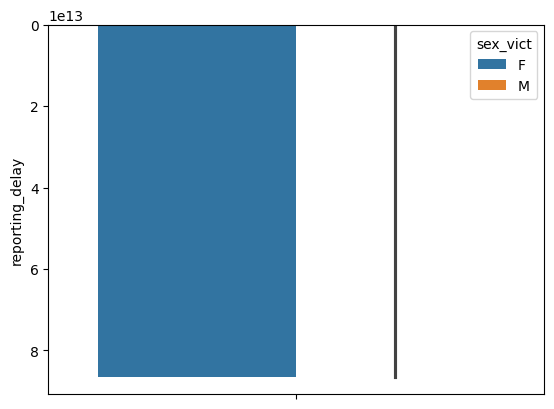

,mean,q1,median,q3
sex_vict,,,,
F,15 days 05:59:40.288022792,0 days,1 days,3 days
M,13 days 13:10:31.377945983,0 days,0 days,2 days


In [44]:
# Let's plot the median delay per gender
sns.barplot(y = 'reporting_delay',
            data = crimes.loc[crimes['sex_vict'].isin(['F','M'])],
            hue = 'sex_vict',
            estimator = 'median')
plt.show()

# We get interesting results, let's look at raw numbers
# Lets define two functions to pass q1 and q3 to agg()
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

# Lets aggregate (note that we subset the DataFrame to only keep record for which we know gender)
display(crimes.loc[crimes['sex_vict'].isin(['F','M'])].groupby('sex_vict')['reporting_delay'].agg(['mean', q1, 'median', q3]))

Overall, men report the crimes they were victims of quicker than women. Maybe they are not targeted by the same type of crimes, maybe this is partly due to psychological and social traits, there might be a lot of reasons for that. Still, 50% of men do not wait to report a crime while the same 50% of women need 1 day to report it.

##### What is the average reporting delay by crime category?

In [45]:
# We can perform the exact same piece of analysis than in the previous question

# We get interesting results, let's look at raw numbers
# Lets aggregate (note that we subset the DataFrame to only keep record for which we know gender)
display(crimes.groupby('crime_cat')['reporting_delay'].agg(['mean', q1, 'median', q3]))

,mean,q1,median,q3
crime_cat,,,,
Assault,4 days 05:21:07.277360699,0 days,0 days,0 days
Burglary,7 days 09:51:00.902346099,0 days,1 days,2 days
Court Violations,5 days 09:18:12.993630573,0 days,0 days,1 days
Employee Crimes,97 days 17:54:31.065989848,6 days,19 days,64 days
Fraud,56 days 11:55:05.900151286,1 days,8 days,40 days
Human Trafficking,103 days 20:41:22.758620690,0 days,0 days,30 days
Miscellaneous,8 days 14:20:20.338983050,0 days,0 days,1 days
Petty Theft,3 days 09:36:00,0 days,3 days,4 days
Property Crime,6 days 05:43:17.769124150,0 days,1 days,2 days


It appears that Human Trafficking and Employee Crimes are, on average, the type of crimes that are reported the longer after being perpetrated. It is especially concerning for the latter since you wouldn't necessarily expect these numbers. Still, 50% of this type of crimes need 19 days to be reported. 

## Insights

The Los Angeles Police Department commissioned our data consulting firm to provide them with actionable insights to better allocate police human resources in the Streets of Las Angeles. After having conducted an Exploratory Data Analysis of the dataset provided, we were able to offer the following guidelines:
- Since most crimes happen at 12:00 AM all around the city, this hour should have the most police officers available in Los Angeles.
- Teams should be particularly cautious of calls for intervention in 77th Street, Southeat, 0 Rampa, 26 New, and 377 Ha since they display the highest frequencies of Very severe crimes, with more than 40% of crimes in these areas.
- Regarding these crimes categorized as Very Severe, youngsters are the age group where the probability of being a victim of a Very severe crime is the highest with an impressively high 83% chance. Therefore, the LAPD could engage in communication campaigns targeting youngsters and increase the protection in streets in areas where they hang out the most.
- 77th Street, Hollywood, and Central are the areas of L.A. with the highest numbers of night crimes. They could be areas to target for patrols at night.
- Women generally take more time to report a crime. Overall, employee crimes are reported 19 days after being perpetrated. Partnerships between the LAPD and companies concerned by these issues could be envisioned to accompany victims of crimes at work.bo
bor 